In [1]:
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import VGG19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

Using TensorFlow backend.


In [2]:
import numpy as np

def load_file(path):
    image = Image.open(path)
    max_dim = 512
    factor = max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    print(image.size)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a 
                                                #batch of single image
    print("After expanding:{}".format(im_array.shape))    
    return im_array

In [3]:
def im_show(img,title=None):
    img = np.squeeze(img,axis=0)
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))    

In [4]:
content_path = "./images/inputs/content/ancient_city.jpg"
style_path = "./images/inputs/style/starry_night_crop.png"

In [5]:
content = load_file(content_path)
style = load_file(style_path)

(512, 288)
After expanding:(1, 288, 512, 3)
(321, 512)
After expanding:(1, 512, 321, 3)


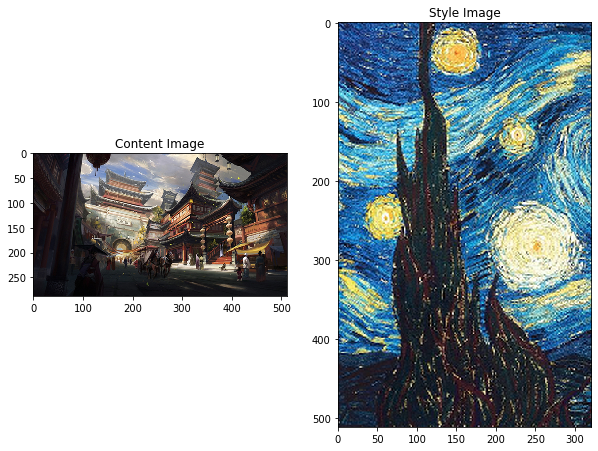

In [6]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
im_show(content,"Content Image")
plt.subplot(1,2,2)
im_show(style,'Style Image')
plt.show()

In [8]:
def img_preprocess(path):
    image = load_file(path)
    img = tf.keras.applications.vgg19.preprocess_input(image)
    return img

#### VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.



In [9]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if(len(x.shape) == 4):
        x = np.squeeze(x,0)
    assert len(x.shape) == 3
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # converting BGR to RGB channel

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
im=img_preprocess(content_path)

(512, 288)
After expanding:(1, 288, 512, 3)


In [11]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

In [13]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    print(content_output)
    print(style_output)
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [14]:
model=get_model()
model.summary()

[<tf.Tensor 'block5_conv2/Identity:0' shape=(None, None, None, 512) dtype=float32>]
[<tf.Tensor 'block1_conv1/Identity:0' shape=(None, None, None, 64) dtype=float32>, <tf.Tensor 'block2_conv1/Identity:0' shape=(None, None, None, 128) dtype=float32>, <tf.Tensor 'block3_conv1/Identity:0' shape=(None, None, None, 256) dtype=float32>, <tf.Tensor 'block4_conv1/Identity:0' shape=(None, None, None, 512) dtype=float32>, <tf.Tensor 'block5_conv1/Identity:0' shape=(None, None, None, 512) dtype=float32>]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
________________________

## Loss Functions

#### Neural style transfer is done by defining two loss functions that try to minimise the differences between a content image, a style image and a generated image. Take the base input image, the content image and the style image that needs to be matched and transform the base input image by minimizing the content and style distances (losses) with backpropagation, creating an image that matches the content of the content image and the style of the style image.

#### The content loss function ensures that the activations of the higher layers are similar between the content image and the generated image. The style loss function makes sure that the correlation of activations in all the layers are similar between the style image and the generated image.

## Content Loss

#### Essentially content loss captures the root mean squared error between the activations produced by the generated image and the content image.

In [53]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

## Style Loss

#### The goal is to compute a style matrix for the generated image and the style image. Then the style loss is defined as the root mean square difference between the two style matrices. Style information is measured as the amount of correlation present between features maps in a given layer. Next, a loss is defined as the difference of correlation present between the feature maps computed by the generated image and the style image. The gram matrix is used to find the correlation between the feature maps of a convolution layer.

In [44]:
def gram_matrix(tensor):
    print("Tensor:....")
    print(tensor)
    print(tensor.shape)
    channels = int(tensor.shape[-1])
    vector = tf.reshape(tensor,[-1,channels])
    print("Vector:....")
    print(vector)
    print(vector.shape)
    n = tf.shape(vector)[0]
    gram_matrix = tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [45]:
def get_style_loss(noise,target):
    gram_noise = gram_matrix(noise)
    loss = tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [46]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output = model(content_img)
    style_output = model(style_image)
    
    for layer in content_output[number_style:]:
        print(layer)
        break 
        
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature

In [47]:
def compute_loss(model,loss_weights,image,gram_style_features,content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output = model(image)
    content_loss = 0
    style_loss = 0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

#### Gradient Loss

In [48]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [49]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [50]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [51]:
def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

#### Style Transfer Visualization

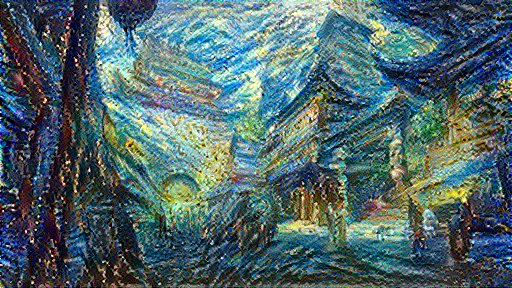

Epoch: 495
Total loss: 2.2651e+06, style loss: 6.5316e+05, content loss: 1.6119e+06, 
Tensor:....
tf.Tensor(
[[[143.10101      0.46685463   0.         ...  63.019985     0.
     0.        ]
  [  0.           6.8212337    0.         ...  66.85585      0.
     0.        ]
  [ 96.80767     49.85098      3.8332622  ...  79.26432      0.
     0.        ]
  ...
  [110.05735     20.297174     0.         ...  80.654976     0.
     0.        ]
  [144.90721     11.902919     0.         ...  97.930405     0.
     0.        ]
  [ 63.718056     0.           0.         ...  47.05759      0.
     0.        ]]

 [[105.14116      8.917493    26.95922    ... 131.52849    133.96326
   126.202484  ]
  [  0.          15.59984      0.         ... 142.00873      0.
     0.        ]
  [  4.4430656   55.376114     2.7580194  ... 119.09948      0.
     0.        ]
  ...
  [ 60.12575     30.985773     0.         ... 145.62134      0.
     0.        ]
  [ 60.875706     7.718581     0.         ... 154.11575      0

In [54]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=500)

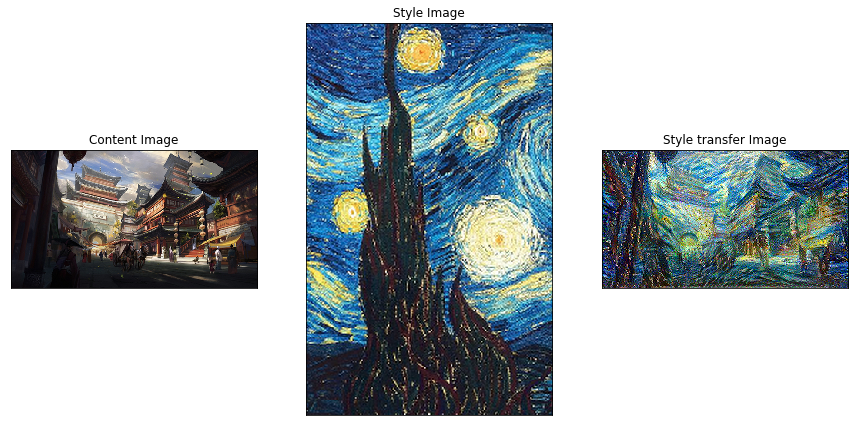

In [56]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
im_show(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
im_show(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

Link followed: https://www.kaggle.com/sayakdasgupta/neural-style-transfer-using-vgg19